# Sentinel-2 Data Processing


Welcome! 

This notebook will guide you through a Python workflow to convert [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) data from [Standard Archive Format for Europe (SAFE) format](https://sentiwiki.copernicus.eu/web/safe-format) to [Zarr format]().


The SAFE format has been designed as a common format for archiving and sharing data within European Space Agency (ESA) aand its cooperating agencies. Zarr is a cloud optimized format for storing multi dimensional rasters.


<br>

After completing this notebook, you'll be able to

* understand advantages of cloud native data formats like Zarr, COGs, etc.
* download Sentinel-2 imageries using APIs
* convert imageries from SAFE to Zarr format and 
* read and manipulate Zarr data

The notebook is divided into following sections:

<a href='#1'>1. Introduction to cloud-native geospatial data formats</a>

<a href='#2'>2. Importing necessary libraries and packages</a>

<a href='#3'>3. Downloading Sentinel-2 data</a>

<a href='#4'>4. Conversion of data from SAFE to Zarr format</a>


<a id='1'></a>
### 1. Introduction to cloud-native geospatial data formats

We have started seeing very large geospatial data files these days. Traditional geodata formats like `shape file`, `geojson`, `GeoTIFF`, etc. are not suitable to work on these large scale datasets. Reading them over a network can be very slow. Loading them all at once is also not convenient.

That's where cloud native formats come to play. 

In simple term, cloud native geospatial data formats are those that have been formatted to work in the cloud. Cloud native formats are designed to optimize the storage, access and processing of geodata in the cloud environment. 

Some of the examples of cloud optimized formats are `Geoparquet`, `FlatGeobuf`, `Cloud-Optimized GeoTIFFs`, `Zarr`, etc. 

Some of the main characteristics for cloud optimized formats are:

* Partial reads and parallel reads of data 
* Data chunking
* Internal indexing 
* Data compression
* Metadata optimization

Read more about these characteristics [here](https://eo-college.org/topics/cloud-native-data-formats/). 


Having said that, there is not one particular cloud file format suitable for all kinds of data. We have

* Geoparquet / FlatGeobuf for vectors
* Cloud- Optimized GeoTIFF (COG) for rasters
* Zarr for multi dimensional rasters
* Cloud-Optimized Point Cloud (COPC) for point clouds

Cloud-Native Geospatial Forum (CNG) has a very good [guide for cloud optimized geospatial formats](https://guide.cloudnativegeo.org/). Please check that out for more details. 

<br>

In this notebook, we specifically deal with `Zarr`, a cloud-native format for multi dimensional data.

Zarr stores data in the form of *chunked*, *compressed* and *n-dimensional typed* arrays.  

Zarr divides very large data into small chunks and organize them. Users can just access the chunk that they're interested in or distribute the chunks for processing across many machines instead of loading as a single file. 

You will also see that in the later stages of this notebook. 

Like other cloud native formats, Zarr supports *chunked data storage*, *compression*, *hierarchical structure* in groups and sub groups. It is also *simple and flexible* format to parse and is *cloud friendly*. 

You can learn more about Zarr [here.](https://help.marine.copernicus.eu/en/articles/10401542-introduction-to-the-zarr-format)

<br>


<div class="alert alert-block alert-warning" style="width: 50%; margin-left: 40px;">
    <b>User credentials:</b> Before moving to the next steps, create an account at the <a href="https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/auth?client_id=cdse-public&response_type=code&scope=openid&redirect_uri=https%3A//dataspace.copernicus.eu/account/confirmed/1">Copernicus Data Space Ecosystem</a> if you haven't already. One need to use those credentials in this notebook to download the data. Enter your <i>username</i> and <i>password</i> in the designated space at <a href="./credentials.py">credentials.py</a>

</div>





<a id='2'></a>
### 2. Importing necessary libraries and packages

To run this notebook, we need to import following requirements. 

* `numpy` : Library to work with arrays.
* `matplotlib` : Library for creating static or interactive visualizations in Python.  
* `pandas` : Library for data analysis and manipulation. 
* `geopandas` : makes working with geospatial data in Python easier. 
* `xarray` : Package to help working with multi dimensional arrays in Python. 
* `rioxarray` : xarray extension that focuses on raster data. 
* `requests` : helps in sending HTTP requests in Python. 
* `zarr` : Library for reading and writing Zarr arrays. 

Other than these, we also have `shutil`, `os` and `Pathlib` to handle file operations, file paths, and interact with the operating system. 

An external Python file called `credentials.py` that stores user credentials is also imported.

In [30]:
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import requests
import rioxarray
import shutil
import xarray as xr
import zarr


from credentials import * 

<a id='3'></a>
### 3. Downloading Sentinel-2 data

<a id='31'></a>
#### 3.1 Defining area of interest

You can provide your study area here in [GeoJSON format](https://geojson.org/) in the same directory as this notebook. If you do not have the GeoJSON file yet, you can create one with tools like [geojson.io](https://geojson.io). We have used an example [study area](AOI.geojson) below. 

<div class="alert alert-block alert-warning" style="width: 50%; margin-left: 40px;">
    <b>Warning:</b> Please remember that the area of interest should be a <em>polygon</em>, it should <em>start and end at the same point</em> and coordinates must be provided in <em>EPSG 4326</em>. 
</div>


The study area is read as geodataframe using `geopandas` and a new column `geometry_in_WKT` is added to get the [Well-Known Text](https://libgeos.org/specifications/wkt/) format of the geometry for the next steps. 

In [2]:
gdf = gpd.read_file("AOI.geojson")

gdf['geometry_in_WKT'] = gdf["geometry"].apply(lambda geom: geom.wkt)

area_of_interest = gdf.geometry_in_WKT.iloc[0]

area_of_interest

'POLYGON ((23.28414733532665 42.808855658791515, 23.02422284514182 42.68620447104402, 23.221514928053608 42.52177922523441, 23.539896331693313 42.60788768623789, 23.461605822601342 42.754459145844265, 23.28414733532665 42.808855658791515))'

We do some string manipulation below to make `area_of_interest` compatible for API request in the next section.

In [3]:
area_of_interest = area_of_interest + "'" 
area_of_interest

"POLYGON ((23.28414733532665 42.808855658791515, 23.02422284514182 42.68620447104402, 23.221514928053608 42.52177922523441, 23.539896331693313 42.60788768623789, 23.461605822601342 42.754459145844265, 23.28414733532665 42.808855658791515))'"

#### 3.2 Downloading data

There are several ways you can download Sentinel-2 data from Python. One can use [Earth Engine Python API](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api), [sentinelsat](https://sentinelsat.readthedocs.io/en/stable/), [sentinelhub](https://sentinelhub-py.readthedocs.io/en/latest/index.html) and many more.

In this notebook, we will be using [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) and its available APIs, in particular [OData](https://documentation.dataspace.copernicus.eu/APIs/OData.html), one of the [Catalog APIs](https://dataspace.copernicus.eu/analyse/apis/catalogue-apis). 


<a id='321'></a>
##### 3.2.1 Defining parameters

Here, we define the parameters for the mission, start date and end data of the imageries captured. The bounding box of the study area comes from <a href='#31'>Section 3.1</a>

Please feel free to make changes to `start_date`, `end_date` and `area_of_interest` as per your need.

In [4]:
start_date = "2023-05-01"
end_date = "2023-05-12"
data_collection = "SENTINEL-2"

The URL for the API request is defined below with our parameters. 

We filter the catalogue using `start_date`, `end_date`, `satellite` and `area_of_interest`. But there are more options to filter the catalogue. You can find more about those [here](https://documentation.dataspace.copernicus.eu/APIs/OData.html).


In [5]:
url = (
    f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
    f"$filter=Collection/Name eq '{data_collection}' "
    f"and OData.CSC.Intersects(area=geography'SRID=4326;{area_of_interest}) "
    f"and ContentDate/Start gt {start_date}T00:00:00.000Z "
    f"and ContentDate/Start lt {end_date}T00:00:00.000Z"
)

The first line of code `json = requests.get(url).json()` requests and receives the response from the server, parses the [JSON data](https://www.json.org/json-en.html) and returns a Python object. 

A dataframe is then created from the returned Python object. 

In [6]:
json = requests.get(url).json()

df = pd.DataFrame.from_dict(json['value'])

We can take a look at the whole dataframe or just filter the columns that we are interested to see.

In [7]:
df

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,5dc3e46a-9157-4128-b90e-cff8db125ae6,S2B_MSIL1C_20230503T092029_N0509_R093_T34TFN_2...,application/octet-stream,701422656,2023-05-03T14:26:10.242000Z,2023-05-03T14:33:06.943331Z,2024-06-18T12:06:00.900589Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L1C/2023/05/03/S2B_MSIL...,"[{'Value': 'd0659901b12cdca834d74ea878dabe6d',...","{'Start': '2023-05-03T09:20:29.024000Z', 'End'...",geography'SRID=4326;POLYGON ((22.233812137762 ...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."
1,application/octet-stream,b557eae1-9a6b-4c02-b9c4-0e314ece0417,S2B_MSIL2A_20230503T092029_N0509_R093_T34TGN_2...,application/octet-stream,1100192563,2023-05-03T15:16:41.464000Z,2023-05-03T15:28:42.043875Z,2024-06-18T12:05:17.603862Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/05/03/S2B_MSIL...,"[{'Value': '450ed9920f81c3ceff97337f2f1d06ca',...","{'Start': '2023-05-03T09:20:29.024000Z', 'End'...",geography'SRID=4326;POLYGON ((23.4662891411315...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
2,application/octet-stream,e0b9807f-3455-4650-89f8-50cf09c71de7,S2B_MSIL1C_20230503T092029_N0509_R093_T34TGN_2...,application/octet-stream,782822282,2023-05-03T14:16:43.843000Z,2023-05-03T14:57:34.007830Z,2024-11-15T13:32:14.135976Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L1C/2023/05/03/S2B_MSIL...,"[{'Value': '7e58d7b78e99f51a0061d34f21c716f2',...","{'Start': '2023-05-03T09:20:29.024000Z', 'End'...",geography'SRID=4326;POLYGON ((23.4662891411315...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
3,application/octet-stream,76e0ba41-94fc-4764-b638-57aacab5eaf8,S2B_MSIL2A_20230503T092029_N0509_R093_T34TFN_2...,application/octet-stream,947145948,2023-05-03T15:23:01.378000Z,2023-05-04T01:29:15.068771Z,2024-06-18T12:05:51.203474Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/05/03/S2B_MSIL...,"[{'Value': 'c52086f8fb87376ef0ccfb0013d81cef',...","{'Start': '2023-05-03T09:20:29.024000Z', 'End'...",geography'SRID=4326;POLYGON ((22.233812137762 ...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."
4,application/octet-stream,527c014a-50c1-4880-b429-648ef1d59304,S2A_MSIL1C_20230508T092031_N0509_R093_T34TGN_2...,application/octet-stream,738098629,2023-05-08T14:27:43.761000Z,2023-05-08T14:35:22.094997Z,2024-06-18T06:26:18.166211Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L1C/2023/05/08/S2A_MSIL...,"[{'Value': '91e43100f9c1a70fac9d866e6a98071a',...","{'Start': '2023-05-08T09:20:31.026000Z', 'End'...",geography'SRID=4326;POLYGON ((23.4662891411315...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
5,application/octet-stream,7c32dc01-679e-4ca8-bcea-bb3c4a65b041,S2A_MSIL2A_20230508T092031_N0509_R093_T34TGN_2...,application/octet-stream,1019527017,2023-05-08T15:52:22.227000Z,2023-05-08T16:01:50.306315Z,2024-06-18T06:25:57.231818Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/05/08/S2A_MSIL...,"[{'Value': '5f42805e32293a1596432dafd2dcfae5',...","{'Start': '2023-05-08T09:20:31.026000Z', 'End'...",geography'SRID=4326;POLYGON ((23.4662891411315...,"{'type': 'Polygon', 'coordinates': [[[23.46628..."
6,application/octet-stream,dad771c7-1639-4f4a-b799-b0c1567f9813,S2A_MSIL2A_20230508T092031_N0509_R093_T34TFN_2...,application/octet-stream,1008699001,2023-05-08T16:00:41.049000Z,2023-05-08T16:38:04.150251Z,2024-11-15T06:19:41.564471Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/05/08/S2A_MSIL...,"[{'Value': '4e62fb3408588ea697a5a441939ad999',...","{'Start': '2023-05-08T09:20:31.026000Z', 'End'...",geography'SRID=4326;POLYGON ((22.233812137762 ...,"{'type': 'Polygon', 'coordinates': [[[22.23381..."
7,application/octet-stream,a13a79f8-d7cf-4808-95ed-1ae7d7faed1b,S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_2...,application/octet-stream,737584900,2023-05-08T14:17:41.

In the above dataframe, we see there are two categories of data, `Level-1C(L1C)` and `Level-2A(L2A)`. 

Level-2A products are atmospherically corrected Surface Reflectance products from Level-1C products. Level-1C products provides Top of Atmosphere (TOA) reflectance images. If you are interested to learn more about L2A and L1C products, please check this [official documentation](https://sentiwiki.copernicus.eu/web/s2-products) from Copernicus.

We will be using both `L1C` and `L2A` products in this notebook. 

Two different conversion routines, each for L1C products and L2A products are available in <a href='#4'>Section 4.</a>

Select the number (on the left) of the product that you're interested in. We will pass this as variable in <a href='#323'>Section 3.2.3</a>

For demo purpose, we will use the L1C product at *7th row (or number = 6)* in the dataframe. The `Id` and `name` will be used as a variable for next steps. 

In [18]:
# Change the integer value after iloc as per your need

image_id = df.iloc[6]['Id']
print(image_id)

name = df.iloc[6]['Name']
print(name)

a13a79f8-d7cf-4808-95ed-1ae7d7faed1b
S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_20230508T112124.SAFE


<div class="alert alert-block alert-info" style="width: 30%; margin-left: 200px; text-align: center;">
    <h4><b>Try it yourself !</b></h4>
    <p>Based on what we've learned so far, could you try and obtain information for Level-2A Sentinel-2 products for <b>Berlin, Germany</b> published between the first two weeks of December 2024?  </p>
</div>


##### 3.2.2 Setting up user credentials


A function called `get_keycloak` is defined. The function accepts `username` and `password` from [credentials.py](./credentials.py) and returns the `access token` (if successful) to be used in the download in next section.

The `try-except` block handles any exception encountered during running the program.


In [19]:
def get_keycloak(username, password):
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
        }
    try:
        r = requests.post("https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
        data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Keycloak token creation failed. Response from the server was: {r.json()}"
            )
    return r.json()["access_token"]

access_token = get_keycloak(username, password)

<a id='323'></a>
##### 3.2.3 Writing file to local directory

In this section, we create a `session` and update headers for the session based on our access token from the previous section. 

Using `image_id` from <a href='#321'>Section 3.2.1</a>, the url for the file to be downloaded is set up. 

A `GET request` is sent to retrieve the file. If the request is successful, the file is written to the current directory as `product.zip` chunk by chunk to avoid memory overload due to the large file size.

If the request is not successful, the status code from the response is shown along with the text. 

In [20]:
# create a header with the access token
headers = {"Authorization": f"Bearer {access_token}"}


# create session and update headers
session = requests.Session()
session.headers.update(headers)

# set up URL for the download
url = f"https://download.dataspace.copernicus.eu/odata/v1/Products({image_id})/$value"

# send a GET request to the server
response = session.get(url, stream=True)


# write response to ZIP file
if response.status_code == 200:
    with open("product.zip", "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk: 
                file.write(chunk)

    print("Product successfully downloaded")
else:
    print(f"Failed to download file. Status code: {response.status_code}")
    print(response.text)


Product successfully downloaded


Please experiment with different parameters based on your need.


<a id='4'></a>
### 4. Conversion of data from SAFE to Zarr format

After the successful download in the previous section, we now have a zipped folder named `product` in the same directory as this notebook.

We will first extract the zipped file in the same directory. `os.getcwd()` gives us current working directory, `os.path.join` joins paths and `shutil.unpack_archive` unzips the folder. 


In [21]:
product_path = os.path.join(os.getcwd(),"product.zip")
directory_to_extract = os.getcwd()

shutil.unpack_archive(product_path, directory_to_extract)


Remember, we have a variable called **name** from <a href='#321'>Section 3.2.1</a>.

In [22]:
SAFE_file_path = os.path.join(os.getcwd(), name)
SAFE_file_path

'd:\\aa\\tutorials\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_20230508T112124.SAFE'

In general, Sentinel-2 product in SAFE format is a directory which contains different subfolders, metadata files and other information. 

<figure style="text-align: center;">
  <img src="./images/S2_SAFE_structure.png" width="400">
  <figcaption style="font-size: 14px; font-style: italic;">Sentinel-2 SAFE product content<br><span style="font-size: 12px; color: gray;">Source: https://sentiwiki.copernicus.eu </span></figcaption>
</figure>

Although the general structure for both L1C and L2A product directory are same, there are some differences in their structure. 

For example: All band images are stored in a single subfolder in L1C products but they are categorized by resolution in L2A products. You can also take a look at the downloaded directory to understand more about the structure.

Therefore, two conversion routines are presented here for two product types. Based on the product you selected in [Section 3](#3-downloading-sentinel-2-data), you can either choose Section 4.1 or 4.2

<a id='#41'></a>
#### 4.1 Level-1C products

We will query all the band imageries present inside `GRANULE` folder located inside our *product* folder. There are 12 bands (B01 - B12) for our data. However, we also have a *TCI imagery* in our folder. We will ignore this as this is just an image built from other bands (B02, B03 and B04). 

In [23]:
# using wildcard to filter the imageries
band_files_path = f"{SAFE_file_path}/GRANULE/*/IMG_DATA/*_*_B*.jp2"

band_files = glob.glob(band_files_path)
band_files

['d:\\aa\\tutorials\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_20230508T112124.SAFE/GRANULE\\L1C_T34TFN_A041131_20230508T092028\\IMG_DATA\\T34TFN_20230508T092031_B01.jp2',
 'd:\\aa\\tutorials\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_20230508T112124.SAFE/GRANULE\\L1C_T34TFN_A041131_20230508T092028\\IMG_DATA\\T34TFN_20230508T092031_B02.jp2',
 'd:\\aa\\tutorials\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_20230508T112124.SAFE/GRANULE\\L1C_T34TFN_A041131_20230508T092028\\IMG_DATA\\T34TFN_20230508T092031_B03.jp2',
 'd:\\aa\\tutorials\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_20230508T112124.SAFE/GRANULE\\L1C_T34TFN_A041131_20230508T092028\\IMG_DATA\\T34TFN_20230508T092031_B04.jp2',
 'd:\\aa\\tutorials\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_20230508T112124.SAFE/GRANULE\\L1C_T34TFN_A041131_20230508T092028\\IMG_DATA\\T34TFN_20230508T092031_B05.jp2',
 'd:\\aa\\tutorials\\S2A_MSIL1C_20230508T092031_N0509_R093_T34TFN_20230508T112124.SAFE/GRANULE\\L1C_T34TFN_A041131_20230508T0

Now, we define an empty list `datasets` , loop through individual bands, performs some string manipulation and use `rioxarray` to open the raster images.

To deal with memory overload due to large file size, we split the data into chunks of size 2048 pixels in both dimensions. rioxarray uses `dask` (if installed) as backend for for parallel processing. 

Each raster dataset is then added to the list.

In [24]:
datasets = []
for file in band_files:

    file_path = Path(file)
    filename = file_path.name


    band_parts = filename.split('_')
    band_name = band_parts[-1].split('.')[0]


    ds = rioxarray.open_rasterio(file, chunks={'x': 2048, 'y': 2048})
    ds = ds.squeeze(dim='band', drop=True) 
    ds.name = band_name
    datasets.append(ds)

<div class="alert alert-block alert-warning" style="width: 50%; margin: auto;">
    <b>Warning:</b> If you get some error related to dask in the previous cell, please try using the older version of dask. The author used dask version 2024.11.2
</div>

`xarray` is now used to merge multiple datasets into single dataset. Each object is named accordingly with the help of `ds.name`. 

The dataset content is written to a zarr group and saved locally. 

In [25]:
combined_ds = xr.merge([ds.to_dataset(name=ds.name) for ds in datasets])

name = name[:-5]
combined_ds.to_zarr(f'{name}.zarr')

print("Zarr store successfully created")

Zarr store successfully created


Different Python libraries like [xarray](https://docs.xarray.dev/en/stable/index.html), [Zarr](https://pypi.org/project/zarr/) or [Dask](https://docs.dask.org/en/stable/) can be used to open and manipulate Zarr files. 

We load the dataset from newly created Zarr store using `open_zarr` method from xarray. There are several parameters for open_zarr [here](https://docs.xarray.dev/en/latest/generated/xarray.open_zarr.html#xarray-open-zarr). Please feel free to experiment. 

In [26]:
ds = xr.open_zarr(f'{name}.zarr')
print(ds)

<xarray.Dataset> Size: 14GB
Dimensions:      (y: 16470, x: 16470)
Coordinates:
  * x            (x) float64 132kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 132kB 4.69e+06 4.69e+06 ... 4.8e+06 4.8e+06
Data variables: (12/14)
    B01          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B02          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B03          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B04          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B05          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B06          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    ...           ...
    B09          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B10          (y, x) float32 1GB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    B11          (y, 

In [27]:
# print data variables of the dataset

print (list(ds.data_vars))

['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B8A', 'spatial_ref']


Let's create a `RGB composite` of our imagery. Given the big size of the imagery, we coarsen the data in our array. You can see more about Xarray `coarsen()` method [here](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.coarsen.html). 

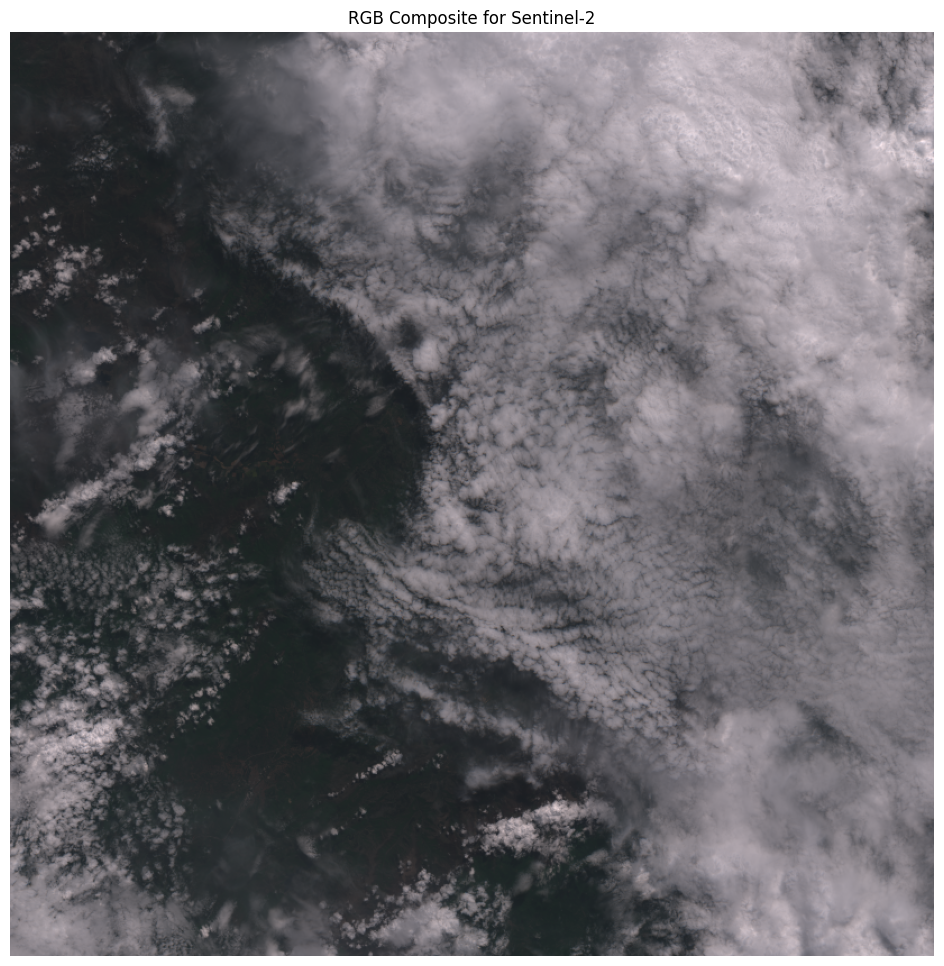

In [28]:
coarsen_factor = 20
boundary = 'trim'


red = ds.B04.coarsen(x=coarsen_factor, y=coarsen_factor, boundary=boundary).mean()
green = ds.B03.coarsen(x=coarsen_factor, y=coarsen_factor, boundary=boundary).mean()
blue = ds.B02.coarsen(x=coarsen_factor, y=coarsen_factor, boundary=boundary).mean()
rgb_array = np.stack([red.values, green.values, blue.values], axis=-1)


plt.figure(figsize=(12, 12))

# normalizing the array values
plt.imshow(rgb_array / np.max(rgb_array))

plt.title('RGB Composite for Sentinel-2')
plt.axis('off')
plt.show()
    

<div class="alert alert-block alert-info" style="width: 30%; margin-left: 200px; text-align: center;">
    <h4><b>Try it yourself !</b></h4>
    <p>Based on what we've learned so far, could you try to obtain <b>Normalized Difference Vegetation Index (NDVI)</b> for a small area in our imagery. You could also coarsen the array like above.</p>
    <p><a href="./solution/ndvi.txt" target="_blank"><b>See Solution</b></a></p>

</div>




<a id='#42'></a>
#### 4.2 Level-2A products

Here, we have conversion codes for L2A products. 

First of all, we define a list for three resolutions for L2A products and an empty dictionary. 

A function `get_filename` is defined which performs some string manipulation on the file names and returns band number and resolution associated with them.

In [14]:
resolutions = ["R10m", "R20m", "R60m"]
resolution_datasets = {}


def get_filename(filename):
    
    basename = os.path.basename(filename)
    parts = basename.split('_')
    band_number = parts[2]
    resolution = parts[3][:3]

    return band_number,resolution  

All band imageries present in different `resolution` in the folder are looped through. 

Individual imageries are opened in chunks using `rioxarray` and an xarray dataset is created for each resolution. 

Finally, individual dataset (for each resolution) is written to one Zarr store with three groups, each group corresponding to one resolution. 

In [15]:
# path to the directory
band_files_path = glob.glob(f"{SAFE_file_path}/GRANULE/*")[0] 

name = name[:-5]

for resolution in resolutions:

    # using wildcard to filter the imageries
    jp2_files = glob.glob(f"{band_files_path}/IMG_DATA/{resolution}/*_*_B*_*.jp2")

    bands_dict = {}

    for file_path in jp2_files:

        band_name, resolution = get_filename(file_path)
        da = rioxarray.open_rasterio(file_path, chunks={'x': 2048, 'y': 2048})
        da = da.squeeze(dim='band', drop=True)
        
        bands_dict[band_name] = da

    if bands_dict:
        resolution_datasets[resolution] = xr.Dataset(bands_dict)


for resolution, ds in resolution_datasets.items():

    
    ds.to_zarr(f'{name}.zarr', group=resolution)


Let's look at the newly created Zarr store and the [groups](https://zarr.readthedocs.io/en/stable/user-guide/groups.html) available in that store.

In [16]:
path_to_store = f'{name}.zarr'
store = zarr.open(path_to_store)

print(list(store.group_keys()))

['10m', '20m', '60m']


Take a look at one of the group.

In [17]:
dataset = xr.open_zarr(f'{name}.zarr', group="20m")
print(dataset)

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 5490, x: 5490)
Coordinates:
  * x            (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 44kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
Data variables:
    B01          (y, x) float64 241MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B02          (y, x) float64 241MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B03          (y, x) float64 241MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B04          (y, x) float64 241MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B05          (y, x) float64 241MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B06          (y, x) float64 241MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B07          (y, x) float64 241MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B11          (y, x) float64 241MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B12          (y, x) float64 

<div class="alert alert-block alert-info" style="width: 30%; margin-left: 200px; text-align: center;">
    <h4><b>Try it yourself !</b></h4>
    <p>Based on what we've learned in this section, could you try to obtain <b>False Color Composite</b> using near infrared, red and green bands of our L2A product for a small area in the imagery.</p>
    <p><a href="./solution/false_composite.txt" target="_blank"><b>See Solution</b></a></p>

</div>




### Summary

In this notebook, we learnt 

* about cloud native data formats
* setting up account at Copernicus Data Space Ecosystem
* downloading Sentinel data using APIs
* converting data from SAFE format to Zarr format and 
* visualizing dataset from Zarr store